In [1]:
!pip install split-folders plotly pandas
import os
import glob
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, preprocessing
from tensorflow.data import Dataset
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import applications 
import numpy as np
from sklearn.model_selection import ParameterSampler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
from tensorflow.keras.applications import DenseNet121 
from tensorflow.keras.applications import InceptionResNetV2
import splitfolders

In [2]:
import shutil
source_dir = "/kaggle/input/pet-scans"
destination_dir = "/kaggle/working/testdata"

# for copying the entire dataset to a writable directory
shutil.copytree(source_dir, destination_dir)

print("Data copied to:", destination_dir)

Data copied to: /kaggle/working/testdata


In [3]:
import os
import shutil

data_dir = "/kaggle/working/testdata"

for root, dirs, files in os.walk(data_dir):
    for dir_name in dirs:
        subfolder_path = os.path.join(root, dir_name)
        for file_name in os.listdir(subfolder_path):
            file_path = os.path.join(subfolder_path, file_name)
            shutil.move(file_path, root)
        os.rmdir(subfolder_path)

print("Files moved up one level. Directory structure is now compatible with splitfolders.")

Files moved up one level. Directory structure is now compatible with splitfolders.


In [4]:
selected_classes = ["breast cancer", "prostate cancer", "No cancer"]
for folder in os.listdir(destination_dir):
    folder_path = os.path.join(destination_dir, folder)
    if folder not in selected_classes:
        if os.path.isdir(folder_path): 
            shutil.rmtree(folder_path)
        else:
            os.remove(folder_path)
print("Filtered dataset to only include breast and lung cancer.")

Filtered dataset to only include breast and lung cancer.


In [5]:
import splitfolders
import glob

data_dir = "/kaggle/working/testdata"
output_dir = "/kaggle/working/output"

splitfolders.ratio(data_dir, output=output_dir, seed=101, ratio=(0.9, 0.05, 0.05))

train_path = os.path.join(output_dir, 'train')
val_path = os.path.join(output_dir, 'val')
test_path = os.path.join(output_dir, 'test')

train_images = glob.glob(f'{train_path}/*/*')  
val_images = glob.glob(f'{val_path}/*/*')      
test_images = glob.glob(f'{test_path}/*/*')   

print("Total number of training images: ", len(train_images))
print("Total number of validation images: ", len(val_images))
print("Total number of test images: ", len(test_images))

Copying files: 1193 files [00:00, 3775.19 files/s]

Total number of training images:  1072
Total number of validation images:  58
Total number of test images:  63


In [6]:
import pandas as pd

train_df = pd.DataFrame()
train_df['Filename'] = pd.Series(train_images).map(lambda img_name: img_name.split("/")[-1])  # Extract filename
train_df['ClassId'] = pd.Series(train_images).map(lambda img_name: img_name.split("/")[-2])  # Extract class label

test_df = pd.DataFrame()
test_df['Filename'] = pd.Series(test_images).map(lambda img_name: img_name.split("/")[-1])  # Extract filename
test_df['ClassId'] = pd.Series(test_images).map(lambda img_name: img_name.split("/")[-2])  # Extract class label

val_df = pd.DataFrame()
val_df['Filename'] = pd.Series(val_images).map(lambda img_name: img_name.split("/")[-1])  # Extract filename
val_df['ClassId'] = pd.Series(val_images).map(lambda img_name: img_name.split("/")[-2])  # Extract class label

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

train_data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.2), 
    tf.keras.layers.RandomZoom(0.2), 
    tf.keras.layers.RandomContrast(0.2), 
    tf.keras.layers.RandomTranslation(0.1, 0.1), 
    tf.keras.layers.Resizing(224, 224),
    tf.keras.layers.Rescaling(1./255),
])
val_test_preprocessing = tf.keras.Sequential([
    tf.keras.layers.Resizing(224, 224),  
    tf.keras.layers.Rescaling(1./255),  
])

train_dataset = image_dataset_from_directory(
    train_path,
    image_size=(224, 224),
    batch_size=16,
    label_mode='int',
    shuffle=True,
    seed=101,
    validation_split=None,
)

val_dataset = image_dataset_from_directory(
    val_path,
    image_size=(224, 224),
    batch_size=16,
    label_mode='int',
    shuffle=False,
    seed=101,
    validation_split=None,
)

test_dataset = image_dataset_from_directory(
    test_path,
    image_size=(224, 224),
    batch_size=16,
    label_mode='int',
    shuffle=False,
    seed=101,
    validation_split=None,
)

class_names = train_dataset.class_names

train_dataset = train_dataset.map(lambda x, y: (train_data_augmentation(x, training=True), y))
val_dataset = val_dataset.map(lambda x, y: (val_test_preprocessing(x), y))
test_dataset = test_dataset.map(lambda x, y: (val_test_preprocessing(x), y))

def remove_alpha(image, label):
    """ Ensure images have only 3 channels (RGB). """
    image = image[:, :, :, :3] 
    return image, label

train_dataset = train_dataset.map(remove_alpha)
val_dataset = val_dataset.map(remove_alpha)
test_dataset = test_dataset.map(remove_alpha)

Found 1072 files belonging to 3 classes.
Found 58 files belonging to 3 classes.
Found 63 files belonging to 3 classes.


In [8]:
import os

def count_images_in_folders(directory):
    """Count the number of images in each class folder."""
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

print("Train class distribution:", count_images_in_folders(train_path))
print("Validation class distribution:", count_images_in_folders(val_path))
print("Test class distribution:", count_images_in_folders(test_path))

Train class distribution: {'prostate cancer': 358, 'breast cancer': 333, 'No cancer': 381}
Validation class distribution: {'prostate cancer': 19, 'breast cancer': 18, 'No cancer': 21}
Test class distribution: {'prostate cancer': 21, 'breast cancer': 20, 'No cancer': 22}


In [9]:
class_labels = np.concatenate([y for x, y in train_dataset], axis=0)
class_weights = compute_class_weight('balanced', classes=np.unique(class_labels), y=class_labels)
class_weights = dict(enumerate(class_weights))

for i, weight in enumerate(class_weights.values()):
    print(f"Class: {class_names[i]}, Weight: {weight:.4f}")

Class: No cancer, Weight: 0.9379
Class: breast cancer, Weight: 1.0731
Class: prostate cancer, Weight: 0.9981


In [10]:
base_model = InceptionResNetV2(include_top=False, input_shape=(224, 224, 3))
base_model.load_weights('/kaggle/input/notop-wg-radimagenet/RadImageNet-IRV2_notop.h5')

base_model.trainable = False

inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = layers.Dropout(0.7)(x) 
num_classes = 3
outputs = layers.Dense(3, activation='softmax')(x)

model = models.Model(inputs, outputs)

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


In [11]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_resnet_v2 (Functional)     │ (None, 5, 5, 1536)          │      54,336,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1536)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       1,573,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │           3,075 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 55,913,699 (213.29 MB)

 Trainable params: 1,576,963 (6.02 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

In [12]:
print(model.output_shape)

(None, 3)


In [13]:
import tensorflow as tf

def focal_loss(alpha=[0.5, 0.3, 0.2], gamma=2.0):
    def loss(y_true, y_pred):
        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[-1])
        y_true = tf.cast(y_true, y_pred.dtype)

        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)

        alpha_t = tf.convert_to_tensor(alpha, dtype=y_pred.dtype)
        alpha_t = tf.reshape(alpha_t, (1, -1)) 

        focal_loss_pos = -y_true * alpha_t * tf.pow(1 - y_pred, gamma) * tf.math.log(y_pred)
        focal_loss_neg = -(1 - y_true) * (1 - alpha_t) * tf.pow(y_pred, gamma) * tf.math.log(1 - y_pred)
        focal_loss_total = focal_loss_pos + focal_loss_neg

        return tf.reduce_mean(focal_loss_total)

    return loss


In [14]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

model.compile(optimizer='adam', loss=focal_loss(alpha=[0.5, 0.3, 0.2], gamma=2.0), metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

def lr_schedule(epoch, lr):
    if epoch < 5:
        return 5e-5  
    elif epoch < 15:
        return 1e-4 
    elif epoch < 25:
        return 5e-5  
    return 1e-5  

lr_warmup = LearningRateScheduler(lr_schedule, verbose=1)

callbacks = [early_stopping, lr_warmup]  

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    class_weight=class_weights,
    callbacks=callbacks
)

model.save("/kaggle/working/frozen_model.h5")
print("Model saved successfully!")

test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Epoch 1: LearningRateScheduler setting learning rate to 5e-05.
Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 58s 465ms/step - accuracy: 0.3898 - loss: 1.2590 - val_accuracy: 0.6552 - val_loss: 1.1096 - learning_rate: 5.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 5e-05.
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 17s 251ms/step - accuracy: 0.5773 - loss: 1.0732 - val_accuracy: 0.6379 - val_loss: 0.9526 - learning_rate: 5.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 5e-05.
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 17s 249ms/step - accuracy: 0.6426 - loss: 0.9190 - val_accuracy: 0.6724 - val_loss: 0.8229 - learning_rate: 5.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 5e-05.
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 17s 250ms/step - accuracy: 0.6254 - loss: 0.7959 - val_accuracy: 0.6724 - val_loss: 0.7125 - learning_rate: 5.0000e-05

Epoch 5: LearningRateScheduler setting learning rate to 5e-05.
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 17s 251ms/step

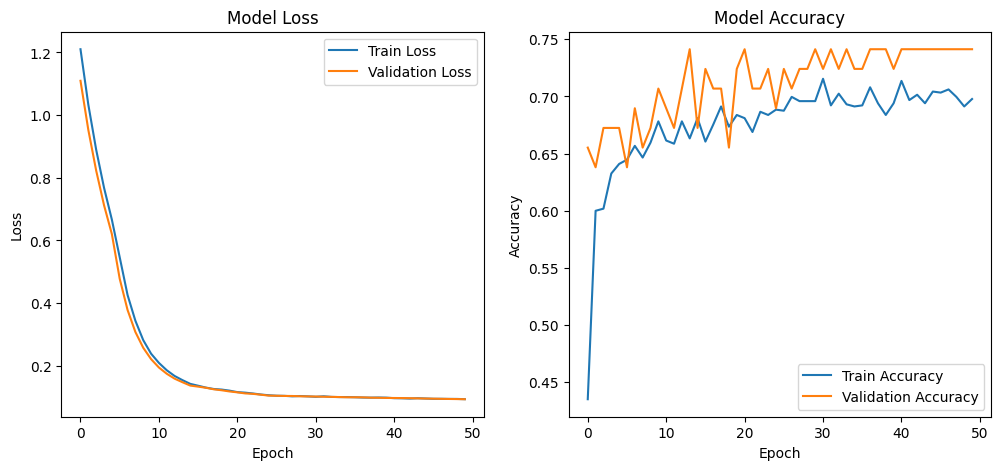

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step


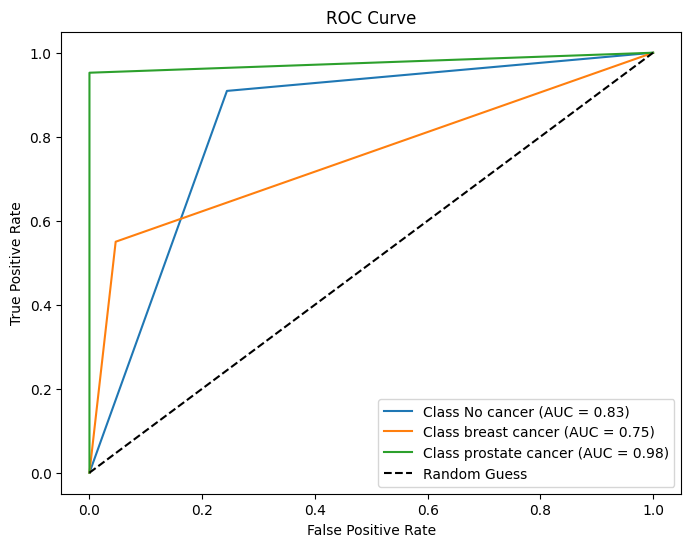

In [16]:
from sklearn.metrics import roc_curve, auc
import numpy as np

y_pred = model.predict(test_dataset)
y_pred = np.argmax(y_pred, axis=1)

y_true = np.concatenate([y for x, y in test_dataset], axis=0)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred == i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

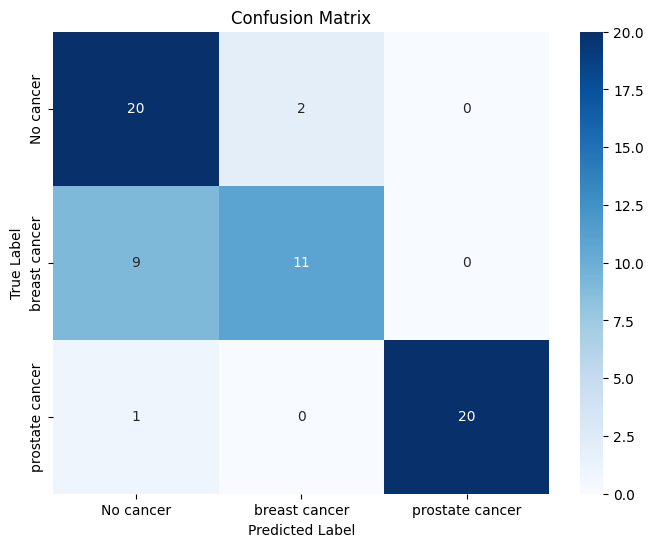

Classification Report:
                 precision    recall  f1-score   support

      No cancer       0.67      0.91      0.77        22
  breast cancer       0.85      0.55      0.67        20
prostate cancer       1.00      0.95      0.98        21

       accuracy                           0.81        63
      macro avg       0.84      0.80      0.80        63
   weighted avg       0.83      0.81      0.81        63

Overall Accuracy: 0.8095
Overall F1 Score: 0.8055


In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

from sklearn.metrics import classification_report, accuracy_score, f1_score


report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

overall_accuracy = accuracy_score(y_true, y_pred)
print(f"Overall Accuracy: {overall_accuracy:.4f}")

overall_f1_score = f1_score(y_true, y_pred, average='weighted')
print(f"Overall F1 Score: {overall_f1_score:.4f}")